In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from tqdm.notebook import tqdm, tnrange
from PIL import Image
import matplotlib.pyplot as plt
import torchsummary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
# Set random seed for reproducibility
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

In [3]:
# lfw_dataset = foz.load_zoo_dataset(
#     "lfw",
#     split="train",
#     shuffle=True,
#     seed=0
# )
# load data from local
lfw_dataset = fo.Dataset.from_dir(
    dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
    dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
    name='lfw_funneled',
    overwrite=True,
    
)


 100% |█████████████| 13233/13233 [3.5s elapsed, 0s remaining, 3.8K samples/s]      


In [4]:
DIM = 224

In [ ]:
class LFWDataset:
    def __init__(self, dataset, dim=DIM):
        self.dataset = dataset
        self.filepaths = list(dataset.values("filepath"))
        self.dim = dim
    
    def __len__(self):
        return len(self.filepaths)
    
    def preprocess(self, image, dim):
        image = image.resize((dim, dim))
        return image
    
    def image_path(self, idx):
        return self.filepaths[idx]
    
    def __getitem__(self, idx):
        impath = self.filepaths[idx]
        sample = self.dataset[impath]
        image = Image.open(impath).convert("RGB")
        image = self.preprocess(image, self.dim)
        image = np.array(image)
        label = sample["ground_truth"]["label"]
        return image, label
    
full_dataset = LFWDataset(lfw_dataset, dim=DIM)
print(full_dataset.image_path(7))

/home/ichitu/fiftyone/lfw/lfw_funneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg


In [6]:
def parse_fglfw_pairs(file_path, dataset_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]

    sets = []
    idx = 0
    # Each set has 600 lines for matched (300 pairs) and 600 lines for mismatched (300 pairs)
    for _ in range(10):
        matched = []
        mismatched = []
        # Read 300 matched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            matched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        # Read 300 mismatched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            mismatched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        sets.append({"matched": matched, "mismatched": mismatched})

    return sets

In [7]:
file_path = "/home/ichitu/fiftyone/lfw/lfw_funneled/pair_FGLFW.txt"
pairs = parse_fglfw_pairs(file_path, "/home/ichitu/fiftyone/lfw/lfw_funneled")
print("Parsed", len(pairs), "sets.")
print("Each set has:", len(pairs[0]["matched"]), "matched pairs and", len(pairs[0]["mismatched"]), "mismatched pairs.")

Parsed 10 sets.
Each set has: 300 matched pairs and 300 mismatched pairs.


### Generating batches with anchor, positive and negative

In [8]:
def batch_generator(dataset, pairs, batch_size, dim=DIM, dataset_path="/home/ichitu/fiftyone/lfw/lfw_funneled"):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors_positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    anchors_negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    while True:
        for i in range(batch_size):
            # Select a random set
            set_ = random.choice(pairs)
            # Select a random matched pair
            matched_pair = random.choice(set_["matched"])
            # Select a random mismatched pair
            mismatched_pair = random.choice(set_["mismatched"])
            # Load the images
            anchor_positive = Image.open(matched_pair[0]).convert("RGB")
            positive = Image.open(matched_pair[1]).convert("RGB")
            anchors_negative = Image.open(mismatched_pair[0]).convert("RGB")
            negative = Image.open(mismatched_pair[1]).convert("RGB")
            # Preprocess the images
            anchor_positive = anchor_positive.resize((dim, dim))
            positive = positive.resize((dim, dim))
            anchors_negative = anchors_negative.resize((dim, dim))
            negative = negative.resize((dim, dim))
            # Convert to numpy arrays
            anchor_positive = np.array(anchor_positive)
            positive = np.array(positive)
            anchors_negative = np.array(anchors_negative)
            negative = np.array(negative)
            # Add to the batch
            anchors_positives[0][i] = anchor_positive
            anchors_positives[1][i] = matched_pair[0]
            positives[0][i] = positive
            positives[1][i] = matched_pair[1]
            anchors_positives[0][i] = anchor_positive / 255.
            anchors_positives[1][i] = matched_pair[0].replace(dataset_path + "/","").split("/")[0]
            positives[0][i] = positive / 255.
            positives[1][i] = matched_pair[1].replace(dataset_path + "/","").split("/")[0]
            anchors_negatives[0][i] = anchors_negative / 255.
            anchors_negatives[1][i] = mismatched_pair[0].replace(dataset_path + "/","").split("/")[0]
            negatives[0][i] = negative / 255.
            negatives[1][i] = mismatched_pair[1].replace(dataset_path + "/","").split("/")[0]
        yield [anchors_positives, positives, anchors_negatives, negatives]
        


In [9]:
def batch_generator3(dataset, batch_size, dim=DIM):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]

    while True:
        for i in range(batch_size):
            if len(dataset) <= 0:  # Check if the dataset is exhausted
                return  # Stop the generator if the dataset is empty
            anchor_idx = np.random.randint(len(dataset))
            anchor, label = dataset[anchor_idx]
            positive_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) == label)[0]
            negative_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) != label)[0]
            if len(positive_indices) == 0 or len(negative_indices) == 0:  
                # Check if no valid pairs are available
                continue
            positive_idx = np.random.choice(positive_indices)
            negative_idx = np.random.choice(negative_indices)
            positive, positive_label = dataset[positive_idx]
            negative, negative_label = dataset[negative_idx]

            anchors[0][i] = anchor
            anchors[1][i] = label
            positives[0][i] = positive
            positives[1][i] = positive_label
            negatives[0][i] = negative
            negatives[1][i] = negative_label

        yield anchors, positives, negatives


Testing what the generator does

In [10]:
BS = 1
generator = batch_generator(full_dataset, pairs, BS)

['Michelle_Branch']
['Michelle_Branch']
['Pedro_Malan']
['Yossi_Beilin']


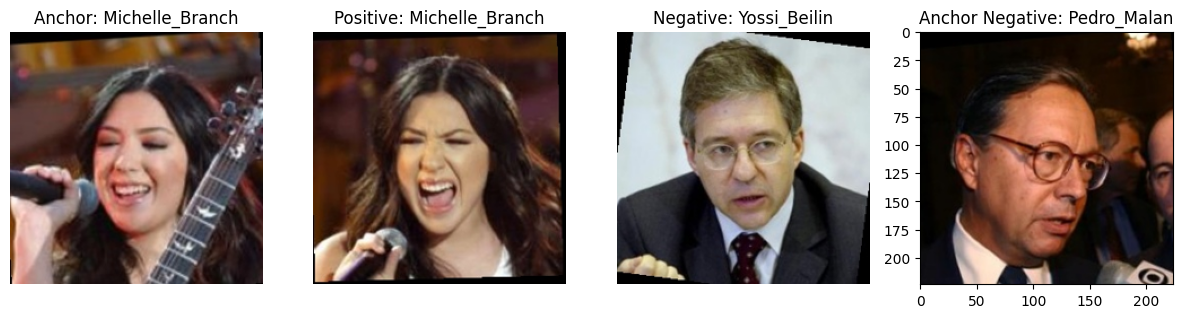

In [11]:
# Get a batch of data
batch = next(generator)
anchor = batch[0]
positive = batch[1]
anchor_negative = batch[2]
negative = batch[3]
print(anchor[1])
print(positive[1])
print(anchor_negative[1])
print(negative[1])
for i in range(BS):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(anchor[0][i])
    ax[0].set_title("Anchor:" + " " + anchor[1][i])
    ax[0].axis("off")
    ax[1].imshow(positive[0][i])
    ax[1].set_title("Positive:" + " " + positive[1][i])
    ax[1].axis("off")
    ax[2].imshow(negative[0][i])
    ax[2].set_title("Negative:" + " " + negative[1][i])
    ax[2].axis("off")
    ax[3].imshow(anchor_negative[0][i])
    ax[3].set_title("Anchor Negative:" + " " + anchor_negative[1][i])
    plt.show()

# Model


In [12]:
class FaceRecZF(nn.Module):
    def __init__(self, input_shape = (3, 220, 220)):
        super(FaceRecZF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        self.conv2a = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3a = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv4a = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.concat = nn.Flatten()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc7132 = nn.Linear(128, 128)

    def L2Norm(self, x):
        return F.normalize(x, p=2, dim=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.rnorm1(x)
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2(x))
        x = self.rnorm2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4a(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5a(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6a(x))
        x = F.relu(self.conv6(x))
        x = self.pool4(x)
        # x = self.concat(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc7132(x)
        return x
    

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FaceRecZF().to(device)
# torchsummary.summary(model, (3, 220, 220))

In [14]:
class FaceRecInception(nn.Module):
    def __init__(self, input_shape=(3, 220, 220)):
        super(FaceRecInception, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        
        # Inception Module 1
        def inception_block1(in_channels, out_channels):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )    
        self.inception1 = inception_block1(64, [64, 192])

        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Modules 1x1, 3x3, 5x5, and Pooling
        def inception_block1x1(in_channels, out_channels):
            conv1x1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            return nn.Sequential(
                conv1x1,
                nn.ReLU()
            )
        def inception_block3x3(in_channels, out_channels, stride=1):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1, stride=stride)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )
        def inception_block5x5(in_channels, out_channels, stride=1):
            conv5x5_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv5x5 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=5, padding=2, stride=stride)
            return nn.Sequential(
                conv5x5_reduce,
                nn.ReLU(),
                conv5x5,
                nn.ReLU()
            )
        
        class L2Pooling(nn.Module):
            def __init__(self):
                super(L2Pooling, self).__init__()
            def forward(self, x):
                return torch.sqrt(F.avg_pool2d(x**2, kernel_size=3, stride=1, padding=1))

        def pool_proj(in_channels, out_channels, max_pool=True):
            if max_pool:
                return nn.Sequential(
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                   )
            else:
                return nn.Sequential(
                    L2Pooling(),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                )
        
        # Inception Module 3a
        self.inception3a1x1 = inception_block1x1(192, [64])
        self.inception3a3x3 = inception_block3x3(192, [96, 128])
        self.inception3a5x5 = inception_block5x5(192, [16, 32])
        self.inception3apool = pool_proj(192, 32, max_pool=True)

        # Inception Module 3b
        self.inception3b1x1 = inception_block1x1(256, [64])
        self.inception3b3x3 = inception_block3x3(256, [96, 128])
        self.inception3b5x5 = inception_block5x5(256, [32, 64])
        self.inception3bpool = pool_proj(256, 64, max_pool=False)

        # Inception Module 3c
        self.inception3c3x3 = inception_block3x3(320, [128, 256], stride=2)
        self.inception3c5x5 = inception_block5x5(320, [32, 64], stride=2)
        self.inception3cpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 4a
        self.inception4a1x1 = inception_block1x1(640, [256])
        self.inception4a3x3 = inception_block3x3(640, [96, 192])
        self.inception4a5x5 = inception_block5x5(640, [32, 64])
        self.inception4apool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4b
        self.inception4b1x1 = inception_block1x1(640, [DIM])
        self.inception4b3x3 = inception_block3x3(640, [112, DIM])
        self.inception4b5x5 = inception_block5x5(640, [32, 64])
        self.inception4bpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4c
        self.inception4c1x1 = inception_block1x1(640, [192])
        self.inception4c3x3 = inception_block3x3(640, [128, 256])
        self.inception4c5x5 = inception_block5x5(640, [32, 64])
        self.inception4cpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4d
        self.inception4d1x1 = inception_block1x1(640, [160])
        self.inception4d3x3 = inception_block3x3(640, [144, 288])
        self.inception4d5x5 = inception_block5x5(640, [32, 64])
        self.inception4dpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4e
        self.inception4e3x3 = inception_block3x3(640, [160, 256], stride=2)
        self.inception4e5x5 = inception_block5x5(640, [64, 128], stride=2)
        self.inception4epool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 5a
        self.inception5a1x1 = inception_block1x1(1024, [384])
        self.inception5a3x3 = inception_block3x3(1024, [192, 384])
        self.inception5a5x5 = inception_block5x5(1024, [48, 128])
        self.inception5apool = pool_proj(1024, 128, max_pool=False)

        # Inception Module 5b
        self.inception5b1x1 = inception_block1x1(1024, [384])
        self.inception5b3x3 = inception_block3x3(1024, [192, 384])
        self.inception5b5x5 = inception_block5x5(1024, [48, 128])
        self.inception5bpool = pool_proj(1024, 128, max_pool=True)

        # Final Pooling and Fully Connected Layer
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(1024, 128)

        # L2 Normalization
        def L2Norm(x):
            return F.normalize(x, p=2, dim=1)
        self.L2Norm = L2Norm

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.rnorm1(x)
        x = self.inception1(x)
        x = self.rnorm2(x)
        x = self.max_pool2(x)

        # Inception Module 3a
        inception3a1x1 = self.inception3a1x1(x)
        inception3a3x3 = self.inception3a3x3(x)
        inception3a5x5 = self.inception3a5x5(x)
        inception3apool = self.inception3apool(x)
        x = torch.cat([inception3a1x1, inception3a3x3, inception3a5x5, inception3apool], 1)

        # Inception Module 3b
        inception3b1x1 = self.inception3b1x1(x)
        inception3b3x3 = self.inception3b3x3(x)
        inception3b5x5 = self.inception3b5x5(x)
        inception3bpool = self.inception3bpool(x)
        x = torch.cat([inception3b1x1, inception3b3x3, inception3b5x5, inception3bpool], 1)

        # Inception Module 3c
        inception3c3x3 = self.inception3c3x3(x)
        inception3c5x5 = self.inception3c5x5(x)
        inception3cpool = self.inception3cpool(x)
        x = torch.cat([inception3c3x3, inception3c5x5, inception3cpool], 1)

        # Inception Module 4a
        inception4a1x1 = self.inception4a1x1(x)
        inception4a3x3 = self.inception4a3x3(x)
        inception4a5x5 = self.inception4a5x5(x)
        inception4apool = self.inception4apool(x)
        x = torch.cat([inception4a1x1, inception4a3x3, inception4a5x5, inception4apool], 1)

        # Inception Module 4b
        inception4b1x1 = self.inception4b1x1(x)
        inception4b3x3 = self.inception4b3x3(x)
        inception4b5x5 = self.inception4b5x5(x)
        inception4bpool = self.inception4bpool(x)
        x = torch.cat([inception4b1x1, inception4b3x3, inception4b5x5, inception4bpool], 1)

        # Inception Module 4c
        inception4c1x1 = self.inception4c1x1(x)
        inception4c3x3 = self.inception4c3x3(x)
        inception4c5x5 = self.inception4c5x5(x)
        inception4cpool = self.inception4cpool(x)
        x = torch.cat([inception4c1x1, inception4c3x3, inception4c5x5, inception4cpool], 1)

        # Inception Module 4d
        inception4d1x1 = self.inception4d1x1(x)
        inception4d3x3 = self.inception4d3x3(x)
        inception4d5x5 = self.inception4d5x5(x)
        inception4dpool = self.inception4dpool(x)
        x = torch.cat([inception4d1x1, inception4d3x3, inception4d5x5, inception4dpool], 1)

        # Inception Module 4e
        inception4e3x3 = self.inception4e3x3(x)
        inception4e5x5 = self.inception4e5x5(x)
        inception4epool = self.inception4epool(x)
        x = torch.cat([inception4e3x3, inception4e5x5, inception4epool], 1)

        # Inception Module 5a
        inception5a1x1 = self.inception5a1x1(x)
        inception5a3x3 = self.inception5a3x3(x)
        inception5a5x5 = self.inception5a5x5(x)
        inception5apool = self.inception5apool(x)
        x = torch.cat([inception5a1x1, inception5a3x3, inception5a5x5, inception5apool], 1)

        # Inception Module 5b
        inception5b1x1 = self.inception5b1x1(x)
        inception5b3x3 = self.inception5b3x3(x)
        inception5b5x5 = self.inception5b5x5(x)
        inception5bpool = self.inception5bpool(x)
        x = torch.cat([inception5b1x1, inception5b3x3, inception5b5x5, inception5bpool], 1)

        # Final Pooling and Fully Connected Layer
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        # L2 Normalization
        x = self.L2Norm(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inception = FaceRecInception().to(device)
# print(model)
torchsummary.summary(model_inception, (3, DIM, DIM))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
 LocalResponseNorm-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
 LocalResponseNorm-8          [-1, 192, 56, 56]               0
         MaxPool2d-9          [-1, 192, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          12,352
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 96, 28, 28]          18,528
             ReLU-13           [-1, 96, 28, 28]               0
           Conv2d-14          [-1, 128,

In [16]:
# ...existing code...
for name, param in model_inception.named_parameters():
    print(name, param.mean().item(), param.std().item())
# ...existing code...

conv1.weight -0.00047529934090562165 0.047891341149806976
conv1.bias 0.0018129664240404963 0.04729199409484863
inception1.0.weight -0.001391479978337884 0.0718919038772583
inception1.0.bias 0.010974201373755932 0.07061164081096649
inception1.2.weight 0.0001299007999477908 0.024127623066306114
inception1.2.bias -0.002118615433573723 0.024009160697460175
inception3a1x1.0.weight 0.0006201685173436999 0.04146965220570564
inception3a1x1.0.bias 0.0006877619307488203 0.04174625501036644
inception3a3x3.0.weight -0.0003942913026548922 0.04151845723390579
inception3a3x3.0.bias -0.00295148859731853 0.0400063581764698
inception3a3x3.2.weight -2.7129810405313037e-05 0.019678162410855293
inception3a3x3.2.bias -0.0003292534383945167 0.020472144708037376
inception3a5x5.0.weight 0.0011678511509671807 0.041826292872428894
inception3a5x5.0.bias -0.006368606351315975 0.043798357248306274
inception3a5x5.2.weight 7.259500853251666e-05 0.028793802484869957
inception3a5x5.2.bias 0.00025253696367144585 0.02736

In [17]:
# get the number of FLOPs and number of parameters
import torch.profiler

model = FaceRecInception().to(device)
model.eval()
inputs = torch.randn(100, 3, DIM, DIM).to(device)
# Use the profiler to estimate FLOPS
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    with_flops=True
    ) as prof:
    model(inputs)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        43.19%      30.466ms        83.56%      58.949ms     999.130us      20.108ms        32.70%      20.108ms     340.810us            59            --  
                                             aten::add_         0.61%     428.730us         1.03%     727.321us      12.327us       6.657ms        10.8

In [18]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, inputs)
print(f"FLOPs: {flops.total()/1e9:.2f} G")

Unsupported operator aten::max_pool2d encountered 6 time(s)
Unsupported operator aten::mul encountered 4 time(s)
Unsupported operator aten::pad encountered 2 time(s)
Unsupported operator aten::avg_pool3d encountered 2 time(s)
Unsupported operator aten::add encountered 2 time(s)
Unsupported operator aten::pow encountered 8 time(s)
Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::avg_pool2d encountered 7 time(s)
Unsupported operator aten::sqrt encountered 6 time(s)
Unsupported operator aten::linalg_vector_norm encountered 1 time(s)
Unsupported operator aten::clamp_min encountered 1 time(s)
Unsupported operator aten::expand_as encountered 1 time(s)


FLOPs: 159.65 G


In [19]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

In [20]:
def train_triplet_loss(model, generator, optimizer, scheduler, device, epochs=25, bathes_per_epoch=100):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches"), generator):
            anchors, positives, negatives,_ = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            # loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss = F.triplet_margin_loss(anchor_embeddings, positive_embeddings, negative_embeddings, margin=0.2)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [21]:
def quartet_loss_1(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    distance_anchor_negative = F.pairwise_distance(anchor, anchor_negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin)) + torch.mean(F.relu(distance_positive - distance_anchor_negative + margin))
    return loss

In [22]:
def quartet_loss_2(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    distance_anchor_negative = F.pairwise_distance(anchor_negative, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin)) + torch.mean(F.relu(distance_positive - distance_anchor_negative + margin))

In [23]:
def train_quartet_loss(model, generator, optimizer,scheduler, device, epochs=25, bathes_per_epoch=100, loss_fn=quartet_loss_2):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            loss = quartet_loss_1(anchor_positive_embeddings, positive_embeddings, negative_embeddings, anchor_negative_embeddings)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [24]:
def equal_distances(a , b):
    distance_a_b = F.pairwise_distance(a, b)
    # print("Distance between a and b:", distance_a_b)
    return distance_a_b

def pair_triplet_loss(anchor_positive, positive, anchor_negative, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor_positive, positive)
    distance_negative = F.pairwise_distance(anchor_negative, negative)

    # assert equal_distances(distance_positive, distance_negative) != 0, "Distance between anchor-positive and anchor-negative is equal to 0."
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

In [25]:
def train_pair_triplet_loss(model, generator, optimizer, scheduler, device, epochs=25, bathes_per_epoch=100):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            # print(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings)
            loss = pair_triplet_loss(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [26]:
# reset the model
model_inception = FaceRecInception().to(device)
optimizer = optim.SGD(model_inception.parameters(), lr=0.05)
generator = batch_generator(full_dataset, pairs, 200)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.9, patience=3)
model_inception, train_losses_sgd = train_triplet_loss(model_inception, generator, optimizer, scheduler, device, epochs=1, bathes_per_epoch=10)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

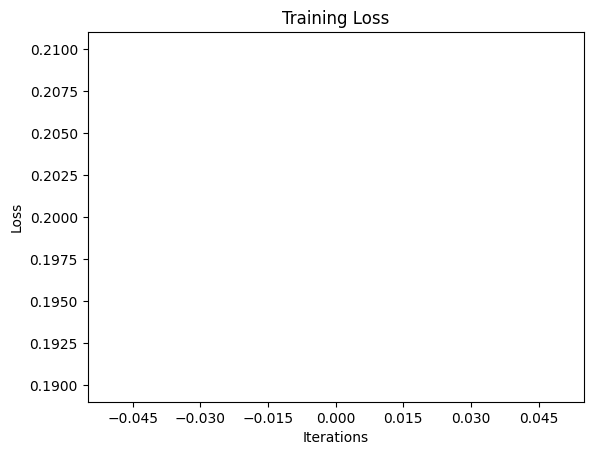

In [27]:
# plot the training loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
ax.plot(train_losses_sgd)


In [28]:
# save the model
torch.save(model_inception.state_dict(), "triplet_loss_mode_SGD.pt")

In [29]:
model_inception = FaceRecInception().to(device)
optimizer = optim.Adagrad(model_inception.parameters(), lr=0.05)
generator = batch_generator(full_dataset, pairs, 150)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2)
# model_inception, train_losses_adagrad = train_quartet_loss(model_inception, generator, optimizer, scheduler, device, epochs=5, bathes_per_epoch=10)
model_inception, train_losses_adagrad = train_triplet_loss(model_inception, generator, optimizer, scheduler, device, epochs=1, bathes_per_epoch=10)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.19984198063611985
Finished Training


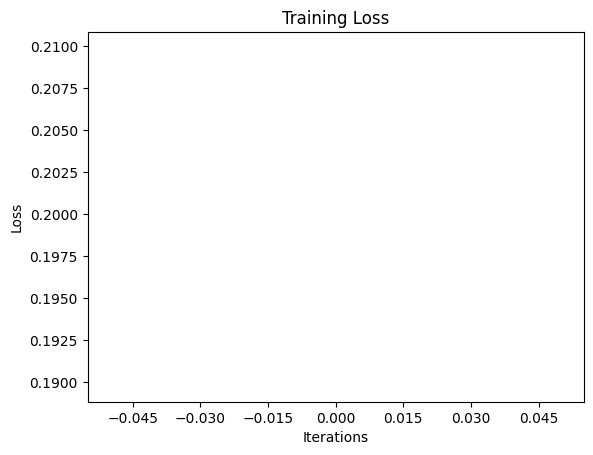

In [30]:
# plot the training loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
ax.plot(train_losses_adagrad)

In [31]:
# save model
torch.save(model_inception.state_dict(), "triplet_loss_mode_Adagrad.pt")

In [32]:
model_inception = FaceRecInception().to(device)
optimizer = optim.Adam(model_inception.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)
generator = batch_generator(full_dataset, pairs, 150)
model_inception, train_losses_adam = train_pair_triplet_loss(model_inception, generator, optimizer, scheduler, device, epochs=100, bathes_per_epoch=1000)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1802989803403616


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2, Loss: 0.17947216902673244


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3, Loss: 0.17966966432332993


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4, Loss: 0.179741685166955


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5, Loss: 0.17975289556384086


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6, Loss: 0.17976137904822825


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7, Loss: 0.17929456210136413


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8, Loss: 0.17984648689627647


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9, Loss: 0.17955260276794432


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10, Loss: 0.1798875970542431


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11, Loss: 0.1799729142487049


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12, Loss: 0.17948398619890213


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13, Loss: 0.17963908740878104


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14, Loss: 0.17983948926627635


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15, Loss: 0.18002534994482994


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16, Loss: 0.1792491571903229


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17, Loss: 0.18003737492859365


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18, Loss: 0.17996876141428947


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19, Loss: 0.179717841938138


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20, Loss: 0.18011492939293386


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21, Loss: 0.1795382432937622


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22, Loss: 0.17922476144135


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23, Loss: 0.17955893927812577


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24, Loss: 0.1796902733296156


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25, Loss: 0.1796231081932783


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26, Loss: 0.1798546712845564


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27, Loss: 0.18009104895591735


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28, Loss: 0.17977548119425774


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29, Loss: 0.180114839553833


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30, Loss: 0.17976967391371726


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31, Loss: 0.18010763247311115


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32, Loss: 0.1798492428958416


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33, Loss: 0.179714486181736


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34, Loss: 0.1797105800062418


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35, Loss: 0.17928020066022873


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36, Loss: 0.17989942221343516


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37, Loss: 0.17927527107298374


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38, Loss: 0.17959183502197265


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39, Loss: 0.18009509283304215


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40, Loss: 0.17987081088125706


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41, Loss: 0.17987061953544617


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42, Loss: 0.17969626441597938


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43, Loss: 0.1801460614800453


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44, Loss: 0.18011690689623355


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45, Loss: 0.18005591084063052


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46, Loss: 0.17944736541807652


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47, Loss: 0.179523599922657


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48, Loss: 0.17931038849055767


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49, Loss: 0.1795762428343296


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50, Loss: 0.17964223943650723


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51, Loss: 0.17953817711770534


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52, Loss: 0.17954208022356033


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53, Loss: 0.18057076242566109


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54, Loss: 0.17977772453427315


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55, Loss: 0.17962460319697857


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56, Loss: 0.1796721338480711


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57, Loss: 0.17954853025078774


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58, Loss: 0.17945052897930144


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59, Loss: 0.1795535826534033


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60, Loss: 0.17972929979860783


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61, Loss: 0.17970513229072094


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62, Loss: 0.1791475306302309


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63, Loss: 0.17940502640604972


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64, Loss: 0.1803342121243477


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65, Loss: 0.17975793021917344


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66, Loss: 0.17953962917625904


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67, Loss: 0.17969913363456727


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68, Loss: 0.1794631972014904


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69, Loss: 0.17976767337322236


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70, Loss: 0.179764862626791


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71, Loss: 0.17928375385701656


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72, Loss: 0.17920705710351467


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73, Loss: 0.17990494471788407


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74, Loss: 0.17963691112399102


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75, Loss: 0.1797092000693083


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76, Loss: 0.17916042765975


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77, Loss: 0.1799404296129942


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78, Loss: 0.17955925600230693


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79, Loss: 0.18001168704032897


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80, Loss: 0.17952508714795112


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81, Loss: 0.1798532660007477


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82, Loss: 0.1799974288791418


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83, Loss: 0.18000071834027767


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84, Loss: 0.17991434510052204


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85, Loss: 0.1794583875834942


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86, Loss: 0.1803494674861431


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87, Loss: 0.17932326385378838


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88, Loss: 0.17944666102528573


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89, Loss: 0.17934237252175808


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90, Loss: 0.17941248467564583


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91, Loss: 0.18006379361450672


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92, Loss: 0.17978235994279385


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93, Loss: 0.18010087923705578


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94, Loss: 0.1799712350219488


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95, Loss: 0.18020322433114053


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96, Loss: 0.17893109607696533


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97, Loss: 0.17964755709469318


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98, Loss: 0.18018810917437075


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99, Loss: 0.1793859024345875


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100, Loss: 0.17960874167084695
Finished Training


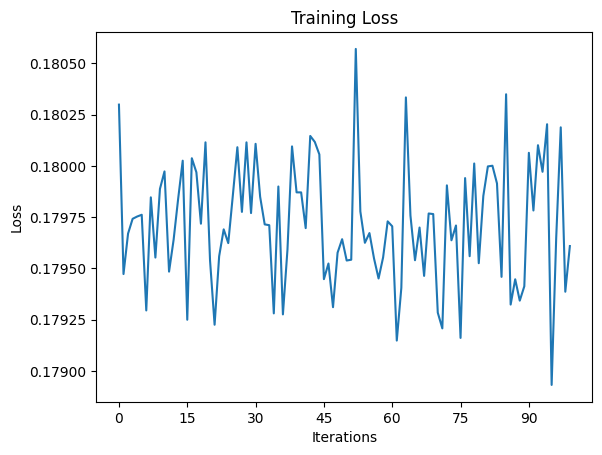

In [33]:
# plot the training loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
ax.plot(train_losses_adam)

In [34]:
# Save the model with timestamp and dimension
tmstmp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model_inception.state_dict(), "{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp))

# clean cuda memory
torch.cuda.empty_cache()

In [35]:
def evaluate3(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tnrange(batches, desc="Batches", leave=False), generator):
            anchors, positives, negatives = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32)

            anchors = torch.transpose(anchors, 1, 3)
            positives = torch.transpose(positives, 1, 3)
            negatives = torch.transpose(negatives, 1, 3)
            # print(anchors.shape, positives.shape, negatives.shape)

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_embeddings, negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)

In [36]:
def evaluate(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tqdm(range(batches), desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_positive_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_positive_embeddings, negative_embeddings)
            distance_anchor_negative = F.pairwise_distance(anchor_positive_embeddings, anchor_negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors_positives)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)
            



In [37]:
generator = batch_generator(full_dataset, pairs, 256)
model_inception = FaceRecInception().to(device)
state_dict = torch.load("{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp), weights_only=True)
# Remove 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model_inception.load_state_dict(state_dict=state_dict)
evaluate(model_inception, generator, device, batches=2)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

| Anchor - Positive | Anchor - Negative |
|-------------------+-------------------|


| 0.041760679334402 | 0.318996131420135 |
| 0.098447099328041 | 0.552775323390961 |
| 0.007434855215251 | 0.159405946731567 |
| 0.284299343824387 | 0.247479990124702 |
| 0.270307183265686 | 0.114806592464447 |
| 0.195885017514229 | 0.007708409335464 |
| 0.058379188179970 | 0.112170137465000 |
| 0.093151077628136 | 0.042176257818937 |
| 0.161979466676712 | 0.280128210783005 |
| 0.152979865670204 | 0.098359890282154 |
| 0.079041145741940 | 0.403544157743454 |
| 0.260567516088486 | 0.013978969305754 |
| 0.103460967540741 | 0.066301040351391 |
| 0.106375865638256 | 0.188591644167900 |
| 0.058815937489271 | 0.052056536078453 |
| 0.071560300886631 | 0.254590123891830 |
| 0.223622441291809 | 0.267020523548126 |
| 0.281809121370316 | 0.113390959799290 |
| 0.152427196502686 | 0.099508270621300 |
| 0.145273149013519 | 0.134874373674393 |
| 0.133004143834114 | 0.044394318014383 |
| 0.090866111218929 | 0.101596884429455 |
| 0.028583772480488 | 0.090328544378281 |
| 0.084822915494442 | 0.1643887758

| 0.107631616294384 | 0.206666931509972 |
| 0.169606238603592 | 0.113273985683918 |
| 0.058466769754887 | 0.095556035637856 |
| 0.137608215212822 | 0.093681797385216 |
| 0.033883985131979 | 0.181378945708275 |
| 0.093253269791603 | 0.078453309834003 |
| 0.132990837097168 | 0.177748456597328 |
| 0.144076153635979 | 0.051479581743479 |
| 0.135912045836449 | 0.087856955826283 |
| 0.289956897497177 | 0.186259150505066 |
| 0.032228156924248 | 0.149262711405754 |
| 0.232265844941139 | 0.025283169001341 |
| 0.155684590339661 | 0.039475422352552 |
| 0.200320303440094 | 0.357954055070877 |
| 0.189753830432892 | 0.077762492001057 |
| 0.128791943192482 | 0.056344725191593 |
| 0.129703864455223 | 0.245004743337631 |
| 0.053508717566729 | 0.190613448619843 |
| 0.483966827392578 | 0.065503373742104 |
| 0.108089879155159 | 0.059476703405380 |
| 0.334556847810745 | 0.451280355453491 |
| 0.023988470435143 | 0.124785266816616 |
| 0.046753525733948 | 0.096398584544659 |
| 0.133004143834114 | 0.1919489204

AnchorP - Positive Distance: 0.32004663348197937
 AnchorP - Negative Distance: 0.36843007802963257
  AnchorP - AnchorN Distance: 0.36750009655952454 
   AnchorN - Negative Distance: 0.030006464570760727


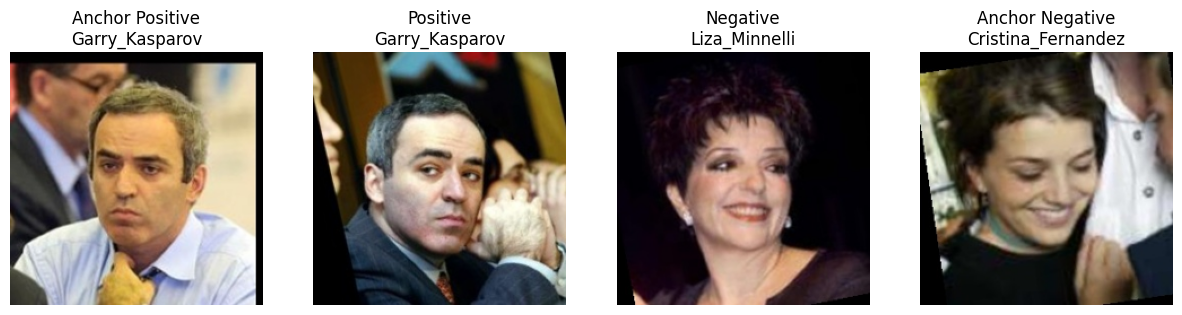

In [38]:
image_generator = batch_generator(full_dataset, pairs, 1)
an_data, pos_data, an_neg_data, neg_data = next(image_generator)
an = torch.tensor(an_data[0], device=device, dtype=torch.float32)
pos = torch.tensor(pos_data[0], device=device, dtype=torch.float32)
neg = torch.tensor(neg_data[0], device=device, dtype=torch.float32)
an_neg = torch.tensor(an_neg_data[0], device=device, dtype=torch.float32)
an_t = torch.transpose(an, 1, 3)
pos_t = torch.transpose(pos, 1, 3)
neg_t = torch.transpose(neg, 1, 3)
an_neg_t = torch.transpose(an_neg, 1, 3)
an_emb = model_inception(an_t)
pos_emb = model_inception(pos_t)
neg_emb = model_inception(neg_t)
an_neg_emb = model_inception(an_neg_t)
distance_positive = F.pairwise_distance(an_emb, pos_emb)
distance_negative = F.pairwise_distance(an_emb, neg_emb)
distance_an_neg = F.pairwise_distance(an_emb, an_neg_emb)
distance_an_neg_negatives = F.pairwise_distance(an_neg_emb, neg_emb)
print(f"AnchorP - Positive Distance: {distance_positive.item()}\n AnchorP - Negative Distance: {distance_negative.item()}\n",
      f" AnchorP - AnchorN Distance: {distance_an_neg.item()} \n   AnchorN - Negative Distance: {distance_an_neg_negatives.item()}")
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 4, 1)
ax.imshow(an[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Positive\n{an_data[1][0]}")
ax = plt.subplot(1, 4, 2)
ax.imshow(pos[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Positive\n{pos_data[1][0]}")
ax = plt.subplot(1, 4, 3)
ax.imshow(neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Negative\n{neg_data[1][0]}")
ax = plt.subplot(1, 4, 4)
ax.imshow(an_neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Negative\n{an_neg_data[1][0]}")
plt.show()


In [39]:
# Check if weights are zero
for name, param in model_inception.named_parameters():
    print(f"{name} - mean: {param.mean().item()}, std: {param.std().item()}")

# Check if gradients are zero
for name, param in model_inception.named_parameters():
    if param.grad is not None:
        print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

conv1.weight - mean: -0.01694348268210888, std: 0.06816156953573227
conv1.bias - mean: -0.056539952754974365, std: 0.06978371739387512
inception1.0.weight - mean: -0.008980600163340569, std: 0.08219926059246063
inception1.0.bias - mean: -0.04446222633123398, std: 0.0954965353012085
inception1.2.weight - mean: -0.004319049883633852, std: 0.04081997275352478
inception1.2.bias - mean: -0.05084247514605522, std: 0.054302994161844254
inception3a1x1.0.weight - mean: -0.004565655253827572, std: 0.053447186946868896
inception3a1x1.0.bias - mean: -0.04426683112978935, std: 0.05109547823667526
inception3a3x3.0.weight - mean: -0.004011217970401049, std: 0.05240960791707039
inception3a3x3.0.bias - mean: -0.03986537083983421, std: 0.0636378824710846
inception3a3x3.2.weight - mean: -0.0014439470833167434, std: 0.03829443082213402
inception3a3x3.2.bias - mean: -0.03640183433890343, std: 0.04481881484389305
inception3a5x5.0.weight - mean: 0.001920119277201593, std: 0.056966301053762436
inception3a5x5.

In [40]:
# Verify loss function
generator = batch_generator(full_dataset, pairs, 1)
model_inception = FaceRecInception().to(device)

# Ensure optimizer is updating parameters
for epoch in range(10):
    optimizer.zero_grad()
    anchors, positives, anchors_negatives, negatives = next(generator)
    anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
    positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
    negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
    anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

    
    anchor_embeddings = model_inception(anchors)
    positive_embeddings = model_inception(positives)
    negative_embeddings = model_inception(negatives)
    anchor_negative_embeddings = model_inception(anchors_negatives)
    
    loss = pair_triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings, anchor_negative_embeddings)
    loss.backward()
    optimizer.step()
    
    print(f"Loss: {loss.item()}")
    for name, param in model_inception.named_parameters():
        if param.grad is not None:
            print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

Loss: 0.2000073492527008
conv1.weight grad - mean: 2.0326315564034303e-07, std: 6.567557875314378e-07
conv1.bias grad - mean: 1.7427716159090778e-07, std: 7.661396921321284e-07
inception1.0.weight grad - mean: 1.305232331105799e-07, std: 6.391747433553974e-07
inception1.0.bias grad - mean: -1.9298403231005068e-07, std: 1.6738723616072093e-06
inception1.2.weight grad - mean: 2.9510813348565534e-08, std: 3.085466175889451e-07
inception1.2.bias grad - mean: 1.2584868258613824e-08, std: 1.7196235830851947e-06
inception3a1x1.0.weight grad - mean: 1.763328683068721e-08, std: 4.0277916468767216e-07
inception3a1x1.0.bias grad - mean: -4.071451655818237e-07, std: 4.3737895794038195e-06
inception3a3x3.0.weight grad - mean: -1.5091190519456177e-08, std: 1.4378575485807232e-07
inception3a3x3.0.bias grad - mean: -3.5001755804842105e-07, std: 1.7500007061244105e-06
inception3a3x3.2.weight grad - mean: -5.520416346271872e-10, std: 1.4828216876594524e-07
inception3a3x3.2.bias grad - mean: -3.961871186

inception4d1x1.0.weight grad - mean: -9.64198605402089e-08, std: 1.1799023695857613e-06
inception4d1x1.0.bias grad - mean: -1.0044332157121971e-05, std: 6.0091082559665665e-05
inception4d3x3.0.weight grad - mean: 3.685088856286711e-08, std: 1.057504505297402e-06
inception4d3x3.0.bias grad - mean: 4.132775302423397e-06, std: 6.464296893682331e-05
inception4d3x3.2.weight grad - mean: 3.7826030307996916e-08, std: 1.82278347438114e-06
inception4d3x3.2.bias grad - mean: -1.3295177723193774e-06, std: 8.309758413815871e-05
inception4d5x5.0.weight grad - mean: 2.2009486144725088e-07, std: 1.0742696758825332e-06
inception4d5x5.0.bias grad - mean: 2.374292307649739e-05, std: 6.180594209581614e-05
inception4d5x5.2.weight grad - mean: 5.702398908624673e-08, std: 1.7633557263252442e-06
inception4d5x5.2.bias grad - mean: 7.064031706249807e-07, std: 9.23783372854814e-05
inception4dpool.1.weight grad - mean: -1.5675629683187253e-08, std: 1.0877087106564431e-06
inception4dpool.1.bias grad - mean: -4.38

Loss: 0.19999071955680847
conv1.weight grad - mean: -4.544935165995412e-07, std: 1.863816009972652e-06
conv1.bias grad - mean: -7.860611503929249e-07, std: 3.413574404476094e-06
inception1.0.weight grad - mean: -2.0930310995481705e-07, std: 1.7578987581146066e-06
inception1.0.bias grad - mean: -9.85618726190296e-07, std: 6.342836513795191e-06
inception1.2.weight grad - mean: -4.831300159935381e-08, std: 8.910534461392672e-07
inception1.2.bias grad - mean: -4.282182999304496e-07, std: 7.033189831417985e-06
inception3a1x1.0.weight grad - mean: -3.766498934965057e-08, std: 9.996567769121611e-07
inception3a1x1.0.bias grad - mean: -1.0993701948791568e-07, std: 1.321959189226618e-05
inception3a3x3.0.weight grad - mean: -2.19166595982756e-09, std: 3.970031343669689e-07
inception3a3x3.0.bias grad - mean: -1.5672451780801566e-08, std: 5.698082986782538e-06
inception3a3x3.2.weight grad - mean: 3.261136782839458e-08, std: 5.041132453698083e-07
inception3a3x3.2.bias grad - mean: 1.8326227291254327

In [27]:
random_samples = fo.Dataset.from_dir(
    dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
    dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
    name='lfw_funneled_random',
    overwrite=True,
    max_samples=100
    
)
random_dataset = LFWDataset(random_samples)

 100% |█████████████████| 100/100 [30.9ms elapsed, 0s remaining, 3.2K samples/s]      


In [28]:
def preprocess_image(image):
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    # image = F.normalize(image)
    image = image.unsqueeze(0)
    return image

def get_image(image):
    return Image.fromarray(image)

def get_images(images):
    return [get_image(image) for image in images]

def get_image_from_sample(sample):
    return get_image(np.array(sample[0]))

def get_images_from_samples(samples):
    return [get_image_from_sample(sample) for sample in samples]

print(len(random_dataset))
images = get_images_from_samples(random_dataset)
print(len(images))

100
100


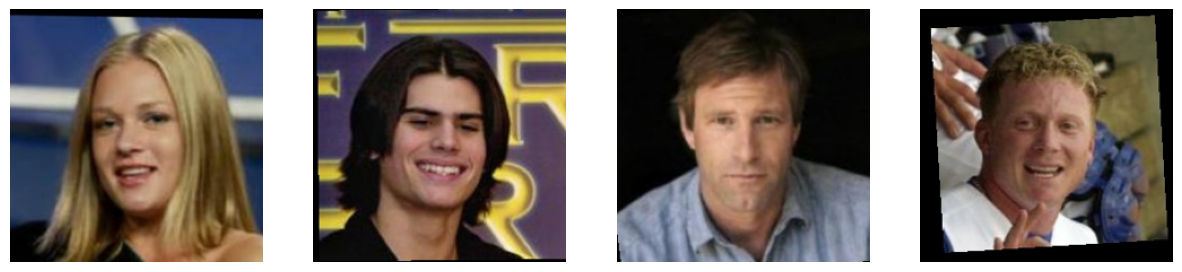

In [29]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.axis("off")

In [30]:
def get_embedding(image):
    image = preprocess_image(image)
    # print(image.shape)
    # plt.imshow(image[0])
    # get image on cuda
    image = image.cuda()
    # get embedding
    embedding = model_inception(image)
    return embedding.cpu().detach().numpy()

def get_embeddings(images):
    embeddings = []
    for image in tqdm(images):
       embeddings.append(get_embedding(image))
    return np.array(embeddings)

In [31]:
embeddings = get_embeddings(images)
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])
print(embeddings.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 128)


In [32]:
results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_tsne",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "tsne",
    
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_pca",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "pca",
    
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_umap",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "umap",
    
)

Generating visualization...


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.000005
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 52.5798454, gradient norm = 0.3304711 (50 iterations in 0.008s)
[t-SNE] Iteration 100: error = 53.0416412, gradient norm = 0.3075606 (50 iterations in 0.008s)
[t-SNE] Iteration 150: error = 54.0998955, gradient norm = 0.2986716 (50 iterations in 0.008s)
[t-SNE] Iteration 200: error = 53.2191200, gradient norm = 0.2846036 (50 iterations in 0.008s)
[t-SNE] Iteration 250: error = 54.0797691, gradient norm = 0.3432382 (50 iterations in 0.008s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.079769
[t-SNE] Iteration 300: error = 0.3030958, gradient norm = 0.0051856 (50 iterations in 0.008s)
[t-SNE] Iteration 350: error = 0.2726533, gradient norm = 0.0012785 (

/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Iteration 550: error = 0.1853886, gradient norm = 0.0004544 (50 iterations in 0.008s)
[t-SNE] Iteration 600: error = 0.1847085, gradient norm = 0.0004971 (50 iterations in 0.008s)
[t-SNE] Iteration 650: error = 0.1853515, gradient norm = 0.0006425 (50 iterations in 0.008s)
[t-SNE] Iteration 700: error = 0.1851452, gradient norm = 0.0005034 (50 iterations in 0.008s)
[t-SNE] Iteration 750: error = 0.1849842, gradient norm = 0.0004422 (50 iterations in 0.008s)
[t-SNE] Iteration 800: error = 0.1848254, gradient norm = 0.0005176 (50 iterations in 0.008s)
[t-SNE] Iteration 850: error = 0.1855083, gradient norm = 0.0004410 (50 iterations in 0.008s)
[t-SNE] Iteration 900: error = 0.1853211, gradient norm = 0.0005980 (50 iterations in 0.008s)
[t-SNE] Iteration 950: error = 0.1848623, gradient norm = 0.0005309 (50 iterations in 0.008s)
[t-SNE] Iteration 950: did not make any progress during the last 300 episodes. Finished.
[t-SNE] KL divergence after 950 iterations: 0.184862
Generating v

/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Mon Jan 20 10:27:04 2025 Construct fuzzy simplicial set
Mon Jan 20 10:27:04 2025 Finding Nearest Neighbors
Mon Jan 20 10:27:07 2025 Finished Nearest Neighbor Search
Mon Jan 20 10:27:09 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 20 10:27:11 2025 Finished embedding


In [33]:

sess = fo.launch_app(dataset=random_samples, port=10100)
sess.open_tab()

<IPython.core.display.Javascript object>